#TF-IDF + SGD script
##Preprocessing
Import statements

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
from nltk import WordNetLemmatizer, word_tokenize, download
from nltk.corpus import stopwords
from sklearn.model_selection import GridSearchCV

download the majority of languages in the dataset as a set, then create a union of them for further sanitation.

In [34]:
download('stopwords')
# Create individual sets for each language's stopwords
english_stopwords = set(stopwords.words('english'))
spanish_stopwords = set(stopwords.words('spanish'))
french_stopwords = set(stopwords.words('french'))
italian_stopwords = set(stopwords.words('italian'))
portuguese_stopwords = set(stopwords.words('portuguese'))
finnish_stopwords = set(stopwords.words('finnish'))
swedish_stopwords = set(stopwords.words('swedish'))
catalan_stopwords = set(stopwords.words('catalan'))
hungarian_stopwords = set(stopwords.words('hungarian'))

# Use the union method to combine all the sets
stop_words = english_stopwords.union(spanish_stopwords, french_stopwords, italian_stopwords, portuguese_stopwords, finnish_stopwords, swedish_stopwords, catalan_stopwords, hungarian_stopwords)

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


define the file paths

In [35]:
# File paths
train_file_path = "mediaeval-2015-trainingset.txt"
test_file_path = "mediaeval-2015-testset.txt"

1.define the pattern of emojis
2.preprocess_text:
replace all urls with a placeholder [U] by pattern matching
convert all texts to lower case
tokenize and lemmatize all the texts
remove all extra white spaces

In [36]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

def preprocess_text(text):
    # Replace URLs with a placeholder
    text = re.sub(r'http\S+|www\S+|https\S+', '[U]', text, flags=re.MULTILINE)
    # Replace emojis with ~
    text = emoji_pattern.sub('~', text)
    # Replace non ascii with
    #text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = text.lower()
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(lemmatized_words)
    # Remove extra whitespaces
    text = text.strip()
    return text

generate_image_id_mapping:
for all imageId(s), in the form of <event>_<label(real/fake)>_<number>, convert them to a dictionary where they are encoded to numbers as the original id could introduce noice to the data.
load_and_process_data:
read all data
for tweetText, after sanitation if they are empty, fill them with ''
replace all humor labels with fake
load all the data and concat them to a string, seperating each attribute with <
return training data as X_train, label as y_train
return testing data as X_test, label as y_test

In [37]:
def generate_image_id_mapping(data):
    unique_image_ids = data['imageId(s)'].unique()
    image_id_dict = {id: f"{i}" for i, id in enumerate(unique_image_ids, start=1)}
    return image_id_dict

def load_and_preprocess_data():
    # Load training dataset
    train_data = pd.read_csv(train_file_path, sep='\t')
    # Handle NaN values for tweetText
    train_data['tweetText'] = train_data['tweetText'].fillna('')

    # Load testing dataset
    test_data = pd.read_csv(test_file_path, sep='\t')
    test_data['tweetText'] = test_data['tweetText'].fillna('')

    # Generate image ID mapping from combined dataset
    combined_data = pd.concat([train_data, test_data])
    image_id_dict = generate_image_id_mapping(combined_data)

    # Replace image IDs with generated IDs in training data
    train_data['imageId(s)'] = train_data['imageId(s)'].map(image_id_dict)
    # Preprocess text and replace labels in training dataset
    train_data['tweetText'] = train_data['tweetText'].apply(preprocess_text)
    train_data['label'] = train_data['label'].replace('humor', 'fake')
    # Select relevant columns for features
    X_train = train_data['tweetText'].astype(str) + '<' + \
              train_data['userId'].astype(str) + '<' + \
              train_data['timestamp'].astype(str) + '<' + \
              train_data['imageId(s)'].astype(str)
    y_train = train_data['label']

    # Replace image IDs with generated IDs in testing data
    test_data['imageId(s)'] = test_data['imageId(s)'].map(image_id_dict)
    # Preprocess text and replace labels in testing dataset
    test_data['tweetText'] = test_data['tweetText'].apply(preprocess_text)
    test_data['label'] = test_data['label'].replace('humor', 'fake')
    # Select relevant columns for features
    X_test = test_data['tweetText'].astype(str) + '<' + \
             test_data['userId'].astype(str) + '<' + \
             test_data['timestamp'].astype(str) + '<' + \
             test_data['imageId(s)'].astype(str)
    y_test = test_data['label']

    return X_train, y_train, X_test, y_test

By calling load_and_preprocess_data(), load the training and testing set
Initialize the pipeline using TF-IDF as feature extractor and SGD as classifier.
Train the model pipeline_tfidf_sgd.fit(X_train, y_train)

In [38]:
X_train, y_train, X_test, y_test = load_and_preprocess_data()

# Define the pipeline
pipeline_tfidf_sgd = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(max_features=3500)),
    ('sgd', SGDClassifier())
])

# Parameters for Grid Search
param_grid = {
    #'sgd__loss': ['hinge', 'log', 'modified_huber'],
    'sgd__penalty': ['l2', 'l1', 'elasticnet'],
    'sgd__alpha': [0.0001, 0.001, 0.01, 0.2],
    #'sgd__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    #'sgd__eta0': [0.1, 0.01, 0.001]
}


# Create grid search object
grid_search = GridSearchCV(pipeline_tfidf_sgd, param_grid, cv=5, scoring='f1_weighted')

Using the trained model, predict on the test set and evaluate against the label, calculate the accuracy.

In [39]:
# Train the model using Grid Search
grid_search.fit(X_train, y_train)

# Best parameter set
print("Best parameters set found on development set:")
print(grid_search.best_params_)

# Evaluate the model with the best parameters
y_pred_tfidf_sgd = grid_search.predict(X_test)
accuracy_tfidf_sgd = accuracy_score(y_test, y_pred_tfidf_sgd)
classification_rep_tfidf_sgd = classification_report(y_test, y_pred_tfidf_sgd, zero_division=1, digits=3)

Best parameters set found on development set:
{'sgd__alpha': 0.0001, 'sgd__penalty': 'elasticnet'}


Plot the result into confusion matrix and print out the result.

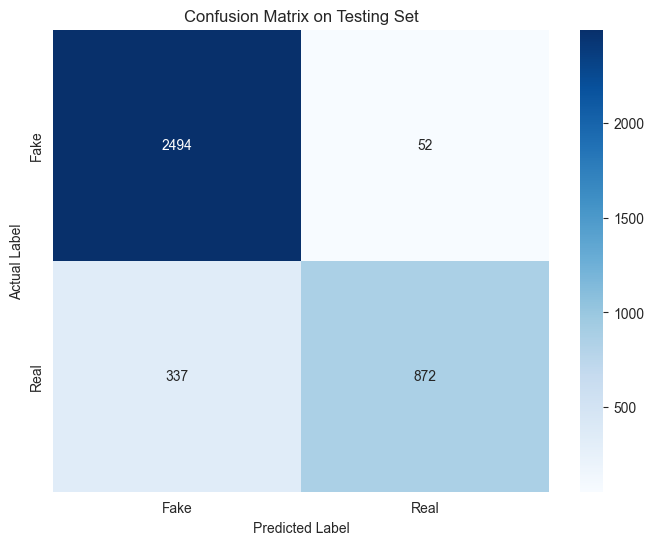

Performance on Testing Set:
Accuracy: 0.896404793608522
Classification Report:
              precision    recall  f1-score   support

        fake      0.881     0.980     0.928      2546
        real      0.944     0.721     0.818      1209

    accuracy                          0.896      3755
   macro avg      0.912     0.850     0.873      3755
weighted avg      0.901     0.896     0.892      3755


In [40]:
# Confusion Matrix for the Testing Set
confusion_matrix_test = confusion_matrix(y_test, y_pred_tfidf_sgd)

# Function to plot confusion matrix
def plot_confusion_matrix(conf_mat, title='Confusion Matrix', labels=['Fake', 'Real']):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(title)
    plt.show()

# Plot Confusion Matrix for Testing Set
plot_confusion_matrix(confusion_matrix_test, title='Confusion Matrix on Testing Set')

# Print the results for the testing set
print('Performance on Testing Set:')
print(f'Accuracy: {accuracy_tfidf_sgd}')
print('Classification Report:')
print(classification_rep_tfidf_sgd)